In [1]:
import matplotlib.pyplot as plt

"""This script will try to apply gaussian process to the Protein-Protein binding affinity data using sklearn GP module first"""
import torch
import esm
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from umap import UMAP
import plotly.express as px
%matplotlib inline

In [15]:
# retrieve all proteins from the dataset
df = pd.read_csv('USE__mutant_seqswoscore.csv', index_col=0)
#df = pd.read_csv('skempiwmutants_nanincl.csv', index_col=0)
df = df[['#Pdb','Mutation(s)_PDB', 'Affinity_mut_parsed','Affinity_wt_parsed','Protein 1', 'Protein 2', 'wild_seq1', 'wild_seq2', 'mutant_seq']]
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,wild_seq1,wild_seq2,mutant_seq
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...
...,...,...,...,...,...,...,...,...,...
7063,3QIB_ABP_CD,AA64G,1.540000e-05,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...
7064,3QIB_ABP_CD,KA67A,1.430000e-05,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...
7065,3QIB_ABP_CD,AA68G,2.290000e-05,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...
7066,3QIB_ABP_CD,EA75A,5.500000e-06,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...


In [45]:
# if there's ":" in the column, just drop first, indicating multi-chain situation
ignore = (df['wild_seq1'].str.contains(':')) | (df['wild_seq2'].str.contains(':')) | (df['mutant_seq'].str.contains(':'))
reduced_df = df[~ignore]
reduced_df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,wild_seq1,wild_seq2,mutant_seq
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...
...,...,...,...,...,...,...,...,...,...
7053,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...
7054,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...
7055,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...
7056,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...


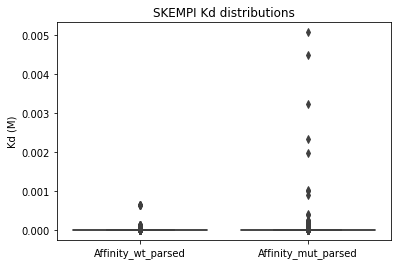

In [40]:
# observe the data first
import seaborn as sns
ax = sns.boxplot(data = reduced_df[['Affinity_wt_parsed', 'Affinity_mut_parsed']])
ax.set(ylabel = 'Kd (M)', title='SKEMPI Kd distributions')
fig = ax.get_figure()
fig.savefig('./outputs/figures/SKEMPI_Kd_distributions.png')
plt.show()

In [47]:
# check and remove if there's any duplicates
reduced_df.drop_duplicates(inplace=True)
df_ = reduced_df.copy()
# shouldn't drop na, na means lose binding ability in mutants
#df_.dropna(inplace=True)
df_['wild_seq_1'] = df_['wild_seq1']
df_['wild_seq_2'] = df_['wild_seq2']
df_['Protein_1'] = df_['Protein 1']
df_['Protein_2'] = df_['Protein 2']
df_ = df_.reset_index(drop=True)
df_

/var/tmp/pbs.805721.hn-10-03/ipykernel_252286/2461256375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df.drop_duplicates(inplace=True)


,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,wild_seq1,wild_seq2,mutant_seq,wild_seq_1,wild_seq_2,Protein_1,Protein_2
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase


In [48]:
"""
    This chunk should re-organize the dataframe so that:
    1. all the sequence listed in wt_seq2 will have positions mutated
    2. if the wt_seq2 and wt_seq1 flipped, so well columns [Protein1, Protein2]
"""
for index, row in df_.iterrows():
    if fuzz.ratio(row['wild_seq1'], row['mutant_seq']) > fuzz.ratio(row['wild_seq2'], row['mutant_seq']) :
        # then the two sequences are similar
        # flip the sequence 1 to sequence 2
            df_.at[index, 'wild_seq_1'] = row['wild_seq2']
            df_.at[index, 'wild_seq_2'] = row['wild_seq1']
            df_.at[index, 'Protein_1'] = row['Protein 2']
            df_.at[index, 'Protein_2'] = row['Protein 1']
    elif fuzz.ratio(row['wild_seq1'], row['mutant_seq'])  < fuzz.ratio(row['wild_seq2'], row['mutant_seq']) :
        pass
    else:
        print(index, fuzz.ratio(row['wild_seq1'], row['mutant_seq']), fuzz.ratio(row['wild_seq2'], row['mutant_seq']))
        print('mutate both sequences?')
df_

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,wild_seq1,wild_seq2,mutant_seq,wild_seq_1,wild_seq_2,Protein_1,Protein_2
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,Colicin E9 DNase,Colicin E2 immunity protein
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase


In [49]:
df_.drop(columns=['Protein 1', 'Protein 2', 'wild_seq1', 'wild_seq2'], inplace=True)
cols = ['#Pdb', 'Mutation(s)_PDB', 'Affinity_mut_parsed', 'Affinity_wt_parsed','Protein_1',
        'Protein_2','wild_seq_1','wild_seq_2', 'mutant_seq']
df_ = df_[cols]
df_

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...
...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...


In [50]:
# Generate sequence embeddings to the proteins
seqs_wt1 = df_.wild_seq_1.values.tolist()
seqs_wt2 = df_.wild_seq_2.values.tolist()
seqs_mut = df_.mutant_seq.values.tolist()
seqs_wt1 = set(seqs_wt1)
seqs_wt2 = set(seqs_wt2)
seqs_mut = set(seqs_mut)
seqs_mut

{'QVEVVTKDERKALHTTASLRCSLKTSQEPLIVTWQKKKAVSPENMVTYSKTHGVVIQPAYKDRINVTELGLWNSSITFWNTTLEDEGCYMCLFNTFGSQKVSGTACLTLYVQPIVHLHYNYFEDHLNITCSATARPAPAISWKGTGTGIENSTESHFHSNGTTSVTSILRVKDPKTQVGKEVICQVLYLGNVIDYKQSLDKGSTRHHHHHH',
 'VDNKFAKEMRNAYWEIALLPNLTNQQKRAFIRSLYDDPSQSSNLLSEAKKLNDSQAPK',
 'LAAVSVDCSEYPKPACCLEYRPLCGSDNKTYGNKCNFCNAVVESNGTLTLSHFGKC',
 'SLDIQSLDIQCEELSDARWAELLPLLQQCQVVRLDDCGLTEARCKDISSALRVNPALAELNLRSNELGDVGVHCVLQGLQTPSCKIQKLSLQNCCLTGAGCGVLSSTLRTLPTLQELHLSDNLLGDAGLQLLCEGLLDPQCRLEKLQLEYCSLSAASCEPLASVLRAKPDFKELTVSNNDINEAGVRVLCQGLKDSPCQLEALKLESCGVTSDNCRDLCGIVASKASLRELALGSNKLGDVGMAELCPGLLHPSSRLRTLWIWECGITAKGCGDLCRVLRAKESLKALSLAGNELGDEGARLLCETLLEPGCQLESLWVKSCSFTAACCSHFSSVLAQNRFLLELQISNNRLEDAGVRELCQGLGQPGSVLRVLWLADCDVSDSSCSSLAATLLANHSLRELDLSNNCLGDAGILQLVESVRQPGCLLEQLVLYDIYWSEEMEDRLQALEKDKPSLRVIS',
 'FPTIPLSRLFDNAMLRAHRLHQLAFDTYQEFEEAYIPKEQKYSFLQNPQTSLCFSESIPTPSNREETQQKSNLELLRISLLLIQSWLEPVQFLRSVFANSLVYGASDSNVYDLLKDLEERIQTLMGRLEDGSPRTGQIFKQTYSKFDTNSHNDDALLKNYGLLYCFRKDMDKVETALRIVQCRSVEGSCGF',

In [51]:
"""lazy to write function, may need to modify in the future"""
seqs_labeled_wt1 = []
count = 0
for seq in seqs_wt1:
    seqs_labeled_wt1.append(tuple((str('seq' + str(count)), seq)))
    count += 1
seqs_labeled_wt2 = []
count = 0
for seq in seqs_wt2:
    seqs_labeled_wt2.append(tuple((str('seq' + str(count)), seq)))
    count += 1
seqs_labeled_mut = []
count = 0
for seq in seqs_mut:
    seqs_labeled_mut.append(tuple((str('seq' + str(count)), seq)))
    count += 1

In [52]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [53]:
# alternative way to generate batches
from torch.utils.data import TensorDataset
from esm import Alphabet, FastaBatchedDataset
batch_size = 1000
dataset = FastaBatchedDataset(list(zip(*seqs_labeled_wt1))[0], list(zip(*seqs_labeled_wt1))[1])
batches = dataset.get_batch_indices(batch_size, extra_toks_per_seq=1)
data_loader = torch.utils.data.DataLoader(dataset, collate_fn=Alphabet.from_architecture("roberta_large").get_batch_converter(),
            batch_sampler=batches, pin_memory=True)
dataset_seq2 = FastaBatchedDataset(list(zip(*seqs_labeled_wt2))[0], list(zip(*seqs_labeled_wt2))[1])
batches_seq2 = dataset_seq2.get_batch_indices(batch_size, extra_toks_per_seq=1)
data_loader_seq2 = torch.utils.data.DataLoader(dataset_seq2, collate_fn=Alphabet.from_architecture("roberta_large").get_batch_converter(),
            batch_sampler=batches_seq2, pin_memory=True)
dataset_mut = FastaBatchedDataset(list(zip(*seqs_labeled_mut))[0], list(zip(*seqs_labeled_mut))[1])
batches_mut = dataset_mut.get_batch_indices(batch_size, extra_toks_per_seq=1)
data_loader_mut = torch.utils.data.DataLoader(dataset_mut, collate_fn=Alphabet.from_architecture("roberta_large").get_batch_converter(),
            batch_sampler=batches_mut, pin_memory=True)

In [54]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
    model = model.cuda()
    print('Transferred model to GPU')

Transferred model to GPU


In [55]:
#QC
for batch_idx, (labels, strs, toks) in enumerate(data_loader):
    print(batch_idx,labels)

0 ['seq58', 'seq11', 'seq19', 'seq105', 'seq32', 'seq18', 'seq49', 'seq99', 'seq65', 'seq78', 'seq36', 'seq26']
1 ['seq47', 'seq51', 'seq45', 'seq38', 'seq92', 'seq94', 'seq14', 'seq6', 'seq67', 'seq74', 'seq76']
2 ['seq84', 'seq25', 'seq59', 'seq86', 'seq34', 'seq64', 'seq82', 'seq91', 'seq33']
3 ['seq48', 'seq50', 'seq102', 'seq70', 'seq61', 'seq73', 'seq16']
4 ['seq57', 'seq83', 'seq87', 'seq104', 'seq28', 'seq41', 'seq69']
5 ['seq72', 'seq60', 'seq24', 'seq27', 'seq107', 'seq81']
6 ['seq12', 'seq23', 'seq29', 'seq79', 'seq85']
7 ['seq106', 'seq46', 'seq10', 'seq56', 'seq98']
8 ['seq43', 'seq2', 'seq95', 'seq40']
9 ['seq42', 'seq108', 'seq39', 'seq96']
10 ['seq55', 'seq93', 'seq0', 'seq20']
11 ['seq97', 'seq4', 'seq68', 'seq53']
12 ['seq54', 'seq30', 'seq88']
13 ['seq3', 'seq63', 'seq13']
14 ['seq1', 'seq37', 'seq100']
15 ['seq44', 'seq8', 'seq80']
16 ['seq31', 'seq90', 'seq71']
17 ['seq101', 'seq75']
18 ['seq21', 'seq15']
19 ['seq22', 'seq17']
20 ['seq62', 'seq9']
21 ['seq66']
22 [

In [56]:
representation_store_dict = {}
for batch_idx, (labels, strs, toks) in enumerate(data_loader):
    if torch.cuda.is_available():
        toks = toks.to(device='cuda', non_blocking=True)
    with torch.no_grad():
        results = model(toks, repr_layers = [33], return_contacts = True)['representations'][33]
        #results = model(toks, repr_layers = [33], return_contacts = True)['logits']
    print(results.shape)
    results_cpu = results.to(device='cpu')
    for i, str_ in enumerate(strs):
        representation_store_dict[str_] = results_cpu[i, 1: (len(strs[i])+1)].numpy()

torch.Size([12, 77, 1280])
torch.Size([11, 88, 1280])
torch.Size([9, 112, 1280])
torch.Size([7, 136, 1280])
torch.Size([7, 138, 1280])
torch.Size([6, 166, 1280])
torch.Size([5, 170, 1280])
torch.Size([5, 188, 1280])
torch.Size([4, 208, 1280])
torch.Size([4, 217, 1280])
torch.Size([4, 225, 1280])
torch.Size([4, 247, 1280])
torch.Size([3, 271, 1280])
torch.Size([3, 277, 1280])
torch.Size([3, 293, 1280])
torch.Size([3, 311, 1280])
torch.Size([3, 333, 1280])
torch.Size([2, 350, 1280])
torch.Size([2, 385, 1280])
torch.Size([2, 416, 1280])
torch.Size([2, 493, 1280])
torch.Size([1, 539, 1280])
torch.Size([1, 541, 1280])
torch.Size([1, 626, 1280])
torch.Size([1, 626, 1280])
torch.Size([1, 627, 1280])
torch.Size([1, 778, 1280])
torch.Size([1, 886, 1280])
torch.Size([1, 970, 1280])


In [57]:
# take the average of the representations of the proteins
# for umaps, along axis 0
sequence_embeddings = {key: np.mean(value, axis=0, keepdims=True) for key, value in representation_store_dict.items()}
#print({key: value.shape for key, value in sequence_embeddings.items()})
sequence_embeddings

{'YMDFDDDIPF': array([[ 0.04850223, -0.00020787, -0.1067889 , ..., -0.11275713,
         -0.04243999,  0.07370986]], dtype=float32),
 'ARTKQTARKSTGGKA': array([[-0.03295479,  0.05730361, -0.00159517, ...,  0.09611291,
         -0.08486195,  0.02019784]], dtype=float32),
 'MVGTCPECGAELRLENPELGELVVCEDCGAELEVVGLDPLRLEPAPEEAEDWGE': array([[-0.0449625 , -0.06565438, -0.07006969, ..., -0.16482054,
         -0.09066245,  0.13345782]], dtype=float32),
 'LAAVSVDCSEYPKPACTLEYRPLCGSDNKTYGNKCNFCNAVVESNGTLTLSHFGKC': array([[ 0.01354975, -0.0449311 , -0.0005479 , ..., -0.14225201,
         -0.12122709,  0.07990506]], dtype=float32),
 'RPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCMRTCGGA': array([[-0.01104478, -0.02331432,  0.00112813, ..., -0.06040942,
         -0.09286413,  0.09454154]], dtype=float32),
 'PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQRTAKYVANQPGMQ': array([[ 0.02592508, -0.0613148 ,  0.01449632, ..., -0.03570469,
         -0.02655147,  0.05187018]], dtype=float32),
 'ATVKFTHQ

In [58]:
representation_store_dict_seq2 = {}
for batch_idx, (labels, strs, toks) in enumerate(data_loader_seq2):
    if torch.cuda.is_available():
        toks = toks.to(device='cuda', non_blocking=True)
    with torch.no_grad():
        results = model(toks, repr_layers = [33], return_contacts = True)['representations'][33]
        #results = model(toks, repr_layers = [33], return_contacts = True)['logits']
    results_cpu = results.to(device='cpu')
    for i, str_ in enumerate(strs):
        representation_store_dict_seq2[str_] = results_cpu[i, 1: (len(strs[i])+1)].numpy()
sequence_embeddings_seq2 = {key: np.mean(value, axis=0, keepdims=True) for key, value in representation_store_dict_seq2.items()}
representation_store_dict_mut = {}
for batch_idx, (labels, strs, toks) in enumerate(data_loader_mut):
    if torch.cuda.is_available():
        toks = toks.to(device='cuda', non_blocking=True)
    with torch.no_grad():
        results = model(toks, repr_layers = [33], return_contacts = True)['representations'][33]
        #results = model(toks, repr_layers = [33], return_contacts = True)['logits']
    results_cpu = results.to(device='cpu')
    for i, str_ in enumerate(strs):
        representation_store_dict_mut[str_] = results_cpu[i, 1: (len(strs[i])+1)].numpy()
sequence_embeddings_mut = {key: np.mean(value, axis=0, keepdims=True) for key, value in representation_store_dict_mut.items()}

In [59]:
def update_embeddings(row, embedding_dict):
    """
    add embeddings to the metadata column.
    cannot do the reverse, because due to mislabel, several different protein names share the same sequences
    but as long as sequences are correct, so will the embeddings
    """
    for key, value in embedding_dict.items():
        if row == key:
            return value
df_['wild_seq_1_embeddings'] = df_['wild_seq_1'].apply(update_embeddings, embedding_dict=sequence_embeddings)
df_['wild_seq_2_embeddings'] = df_['wild_seq_2'].apply(update_embeddings, embedding_dict=sequence_embeddings_seq2)
df_['mutant_seq_embeddings'] = df_['mutant_seq'].apply(update_embeddings, embedding_dict=sequence_embeddings_mut)
df_

/var/tmp/pbs.805721.hn-10-03/ipykernel_252286/11333128.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['wild_seq_1_embeddings'] = df_['wild_seq_1'].apply(update_embeddings, embedding_dict=sequence_embeddings)
/var/tmp/pbs.805721.hn-10-03/ipykernel_252286/11333128.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['wild_seq_2_embeddings'] = df_['wild_seq_2'].apply(update_embeddings, embedding_dict=sequence_embeddings_seq2)
/var/tmp/pbs.805721.hn-10-03/ipykernel_252286/11333128.py:12: SettingWi

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0..."
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046..."
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05..."
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0..."
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,"[[-0.023992453, -0.03358702, -0.03738257, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.040997185, 0.060716324, 0.011485457, 0.042..."
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.024809036, -0.034960907, -0.03911288, 0.0..."


In [60]:
df_.to_csv('reduced_proteins_embeddings_meta.csv', index=False)

In [62]:
# extract meta information to draw umaps
# need to reorganize dataframe to make the features clear for each protein sequence

ppi = df_['Protein_1'] + '---' + df_['Protein_2']
prot_1 = df_['Protein_1']
prot_2 = df_['Protein_2']
prot_mut = df_['Protein_2']+'_'+'mut'
seq_1 = df_['wild_seq_1']
seq_2 = df_['wild_seq_2']
seq_mut = df_['mutant_seq']
embed_1 = df_['wild_seq_1_embeddings']
embed_2 = df_['wild_seq_2_embeddings']
embed_mut = df_['mutant_seq_embeddings']
affinity_wt = df_['Affinity_wt_parsed']
affinity_mut = df_['Affinity_mut_parsed']
label_wt_1 = pd.Series(['wt1']*len(prot_1))
label_wt_2 = pd.Series(['wt2']*len(prot_2))
label_mut = pd.Series(['mut']*len(prot_mut))
pdbs = df_['#Pdb']
mut = df_['Mutation(s)_PDB']
mut_status_wt = pd.Series([np.nan]*len(prot_1))

In [63]:
df_meta = pd.DataFrame({
    'PDB': pd.concat([pdbs, pdbs, pdbs], ignore_index=True),
    'Protein': pd.concat([prot_1, prot_2, prot_mut], ignore_index=True),
    'Mutation': pd.concat([mut_status_wt, mut_status_wt, mut], ignore_index=True),
    'Sequence': pd.concat([seq_1, seq_2, seq_mut], ignore_index=True),
    'PPI': pd.concat([ppi, ppi, ppi], ignore_index=True),
    'Label': pd.concat([label_wt_1, label_wt_2, label_mut], ignore_index=True),
    'Affinity': pd.concat([affinity_wt, affinity_mut, affinity_mut], ignore_index=True),
    'Embedding': pd.concat([embed_1, embed_2, embed_mut], ignore_index=True),
})
df_meta

,PDB,Protein,Mutation,Sequence,PPI,Label,Affinity,Embedding
0,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...
6073,2WPT_A_B,Colicin E9 DNase_mut,FB86A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.410000e-05,"[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
6074,2WPT_A_B,Colicin E9 DNase_mut,"DA33A,FB86A",MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,6.210000e-07,"[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
6075,2WPT_A_B,Colicin E2 immunity protein_mut,NA34A,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,Colicin E9 DNase---Colicin E2 immunity protein,mut,6.490000e-07,"[[0.040997185, 0.060716324, 0.011485457, 0.042..."
6076,2WPT_A_B,Colicin E9 DNase_mut,SB84A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.090000e-07,"[[-0.024809036, -0.034960907, -0.03911288, 0.0..."


In [64]:
expanded_embeddings = df_meta['Embedding'].apply(lambda x: pd.Series(x[0]))
df_umap = pd.concat([df_meta, expanded_embeddings], axis=1)
df_umap.drop(['Embedding'], axis=1, inplace=True)
df_umap

,PDB,Protein,Mutation,Sequence,PPI,Label,Affinity,0,1,2,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
1,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
2,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
3,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
4,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,2WPT_A_B,Colicin E9 DNase_mut,FB86A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.410000e-05,-0.023146,-0.030065,-0.042366,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
6074,2WPT_A_B,Colicin E9 DNase_mut,"DA33A,FB86A",MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,6.210000e-07,-0.023146,-0.030065,-0.042366,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
6075,2WPT_A_B,Colicin E2 immunity protein_mut,NA34A,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,Colicin E9 DNase---Colicin E2 immunity protein,mut,6.490000e-07,0.040997,0.060716,0.011485,...,0.061316,-0.110644,-0.032557,0.077818,0.002379,0.042844,0.068300,-0.051918,-0.032073,0.005497
6076,2WPT_A_B,Colicin E9 DNase_mut,SB84A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.090000e-07,-0.024809,-0.034961,-0.039113,...,0.032787,-0.029683,0.027316,0.041665,0.035929,0.041350,0.160533,-0.034257,0.013173,0.098352


In [65]:
df_umap.drop_duplicates(inplace=True, ignore_index=True)
# weird duplicates should be dropped under the affinity column
# keep the first encounter first
# seems like a lot of wts mistakenly have affinities of mutants
#df_umap= df_umap.drop_duplicates(subset='Affinity', keep='first', ignore_index=True)
df_umap.drop_duplicates(subset=['Sequence','Affinity'], keep='first')
df_umap

,PDB,Protein,Mutation,Sequence,PPI,Label,Affinity,0,1,2,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
1,1ACB_E_I,Bovine alpha-chymotrypsin,NaN,CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...,Bovine alpha-chymotrypsin---Eglin c,wt1,1.490000e-12,-0.024084,-0.075005,0.095740,...,-0.030875,-0.010676,0.019165,0.012005,-0.024776,-0.073066,0.157846,-0.125076,0.007595,0.012058
2,1SBN_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Eglin c,wt1,5.400000e-11,-0.026620,-0.127139,-0.023718,...,-0.008986,-0.038144,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161
3,1SIB_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Eglin c,wt1,1.100000e-10,-0.026620,-0.127139,-0.023718,...,-0.008986,-0.038144,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161
4,1Y1K_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Chymotrypsin inhibitor 2,wt1,3.000000e-10,-0.024234,-0.125870,-0.016005,...,-0.013163,-0.044520,0.007318,0.000455,-0.014147,-0.083658,0.048994,-0.228365,-0.020183,0.054084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,2WPT_A_B,Colicin E9 DNase_mut,FB86A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.410000e-05,-0.023146,-0.030065,-0.042366,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
3892,2WPT_A_B,Colicin E9 DNase_mut,"DA33A,FB86A",MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,6.210000e-07,-0.023146,-0.030065,-0.042366,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
3893,2WPT_A_B,Colicin E2 immunity protein_mut,NA34A,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,Colicin E9 DNase---Colicin E2 immunity protein,mut,6.490000e-07,0.040997,0.060716,0.011485,...,0.061316,-0.110644,-0.032557,0.077818,0.002379,0.042844,0.068300,-0.051918,-0.032073,0.005497
3894,2WPT_A_B,Colicin E9 DNase_mut,SB84A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.090000e-07,-0.024809,-0.034961,-0.039113,...,0.032787,-0.029683,0.027316,0.041665,0.035929,0.041350,0.160533,-0.034257,0.013173,0.098352


In [66]:
features = df_umap.loc[:,0:]
features

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.032167,-0.156764,-0.000668,0.196686,-0.085573,0.036454,0.052018,-0.279040,-0.031406,0.134620,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
1,-0.024084,-0.075005,0.095740,0.091299,-0.071668,-0.049193,0.119715,-0.103854,-0.073772,0.110402,...,-0.030875,-0.010676,0.019165,0.012005,-0.024776,-0.073066,0.157846,-0.125076,0.007595,0.012058
2,-0.026620,-0.127139,-0.023718,0.160727,-0.056114,-0.017783,0.047995,-0.253842,0.008707,0.119826,...,-0.008986,-0.038144,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161
3,-0.026620,-0.127139,-0.023718,0.160727,-0.056114,-0.017783,0.047995,-0.253842,0.008707,0.119826,...,-0.008986,-0.038144,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161
4,-0.024234,-0.125870,-0.016005,0.149271,-0.057436,-0.010698,0.037167,-0.230677,-0.019418,0.123591,...,-0.013163,-0.044520,0.007318,0.000455,-0.014147,-0.083658,0.048994,-0.228365,-0.020183,0.054084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,-0.023146,-0.030065,-0.042366,0.004902,-0.033540,-0.052219,0.021217,-0.160497,0.014909,0.035471,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
3892,-0.023146,-0.030065,-0.042366,0.004902,-0.033540,-0.052219,0.021217,-0.160497,0.014909,0.035471,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
3893,0.040997,0.060716,0.011485,0.042063,-0.066023,0.053417,-0.009934,0.040825,0.072982,-0.072750,...,0.061316,-0.110644,-0.032557,0.077818,0.002379,0.042844,0.068300,-0.051918,-0.032073,0.005497
3894,-0.024809,-0.034961,-0.039113,0.003393,-0.034247,-0.050823,0.022623,-0.158197,0.016020,0.032997,...,0.032787,-0.029683,0.027316,0.041665,0.035929,0.041350,0.160533,-0.034257,0.013173,0.098352


In [67]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(features)
results = {'umap1': proj_2d[:, 0], 'umap2': proj_2d[:, 1]}
umap_results = pd.DataFrame(data=results)
umap_results

,umap1,umap2
0,0.000760,14.393231
1,-0.358848,15.275245
2,0.043616,14.409670
3,0.036589,14.425159
4,0.055435,14.442195
...,...,...
3891,13.339123,-9.568273
3892,13.335716,-9.559145
3893,-28.910667,-25.396225
3894,20.383612,10.121615


In [68]:
df_umap_ = pd.concat([df_umap, umap_results], axis=1)
df_umap_

,PDB,Protein,Mutation,Sequence,PPI,Label,Affinity,0,1,2,...,1272,1273,1274,1275,1276,1277,1278,1279,umap1,umap2
0,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898,0.000760,14.393231
1,1ACB_E_I,Bovine alpha-chymotrypsin,NaN,CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...,Bovine alpha-chymotrypsin---Eglin c,wt1,1.490000e-12,-0.024084,-0.075005,0.095740,...,0.019165,0.012005,-0.024776,-0.073066,0.157846,-0.125076,0.007595,0.012058,-0.358848,15.275245
2,1SBN_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Eglin c,wt1,5.400000e-11,-0.026620,-0.127139,-0.023718,...,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161,0.043616,14.409670
3,1SIB_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Eglin c,wt1,1.100000e-10,-0.026620,-0.127139,-0.023718,...,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161,0.036589,14.425159
4,1Y1K_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Chymotrypsin inhibitor 2,wt1,3.000000e-10,-0.024234,-0.125870,-0.016005,...,0.007318,0.000455,-0.014147,-0.083658,0.048994,-0.228365,-0.020183,0.054084,0.055435,14.442195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,2WPT_A_B,Colicin E9 DNase_mut,FB86A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.410000e-05,-0.023146,-0.030065,-0.042366,...,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678,13.339123,-9.568273
3892,2WPT_A_B,Colicin E9 DNase_mut,"DA33A,FB86A",MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,6.210000e-07,-0.023146,-0.030065,-0.042366,...,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678,13.335716,-9.559145
3893,2WPT_A_B,Colicin E2 immunity protein_mut,NA34A,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,Colicin E9 DNase---Colicin E2 immunity protein,mut,6.490000e-07,0.040997,0.060716,0.011485,...,-0.032557,0.077818,0.002379,0.042844,0.068300,-0.051918,-0.032073,0.005497,-28.910667,-25.396225
3894,2WPT_A_B,Colicin E9 DNase_mut,SB84A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.090000e-07,-0.024809,-0.034961,-0.039113,...,0.027316,0.041665,0.035929,0.041350,0.160533,-0.034257,0.013173,0.098352,20.383612,10.121615


In [70]:
color_dict = {'wt1':'#72B7B2', 'wt2':'#54A24B', 'mut':'#E45756'}
fig= px.scatter(
    df_umap_,
    x = 'umap1',
    y = 'umap2',
    color='Label',
    color_discrete_map=color_dict,
    hover_name='Protein',
    hover_data={
        'Protein': False,
        'PDB': True,
        'Label': True,
        'PPI': True,
        'Mutation':True,
        'Affinity':True,
        'umap1':False,
        'umap2':False
    }
)
fig.update_layout(template='simple_white',
                  title='SKEMPI Protein-Protein embeddings',
                  title_x=0.5
                  )
fig.show()

In [ ]:
fig.write_html("skempi_ppi_plotly.html")